Lap Time: 110.63489714232716 s
Average Battery Current (Continuous): 254.19369831748668
Peak Battery Current: 788.5910110567069
Average Motor Current (Continuous): 228.7743284857383
RMS Motor Current (Continuous): 20544.520637275364
Peak Motor Current: 709.7319099510362
Averge Torque: 73.6311893824289
Number of cells in Series: 33
Min Voltage: 99.0
Number of cells in Parallel: 17
Battery Configuration: 33S17P
Average Battery Power (Continuous): 30.503243798098403
Average Motor Power (Continuous): 27.452919418288594
Peak Battery Power: 94.63092132680482
Peak Motor Power: 85.16782919412434


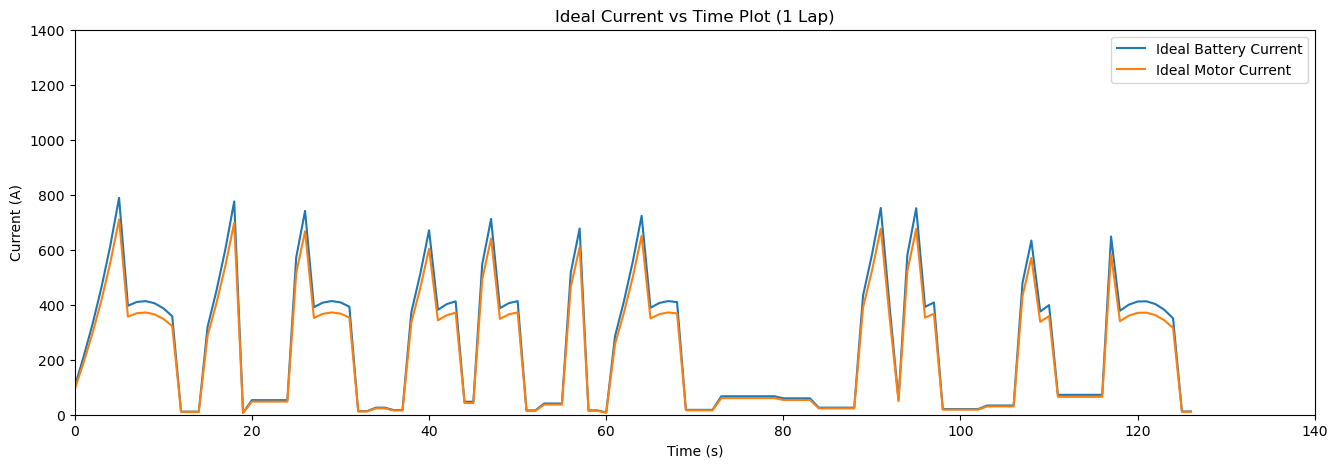

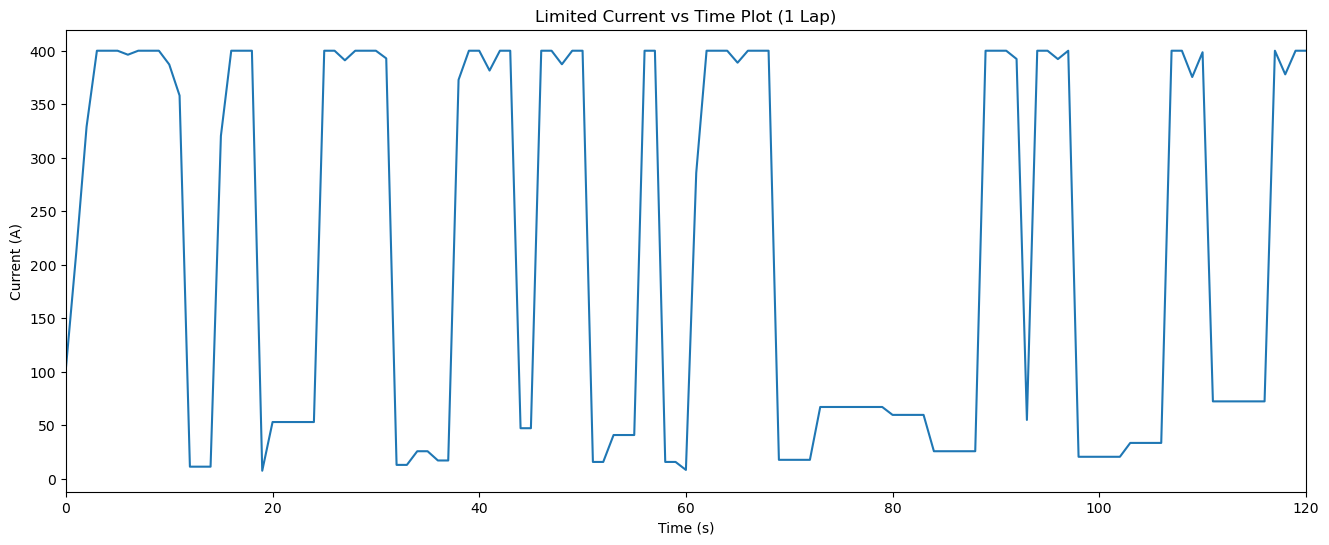

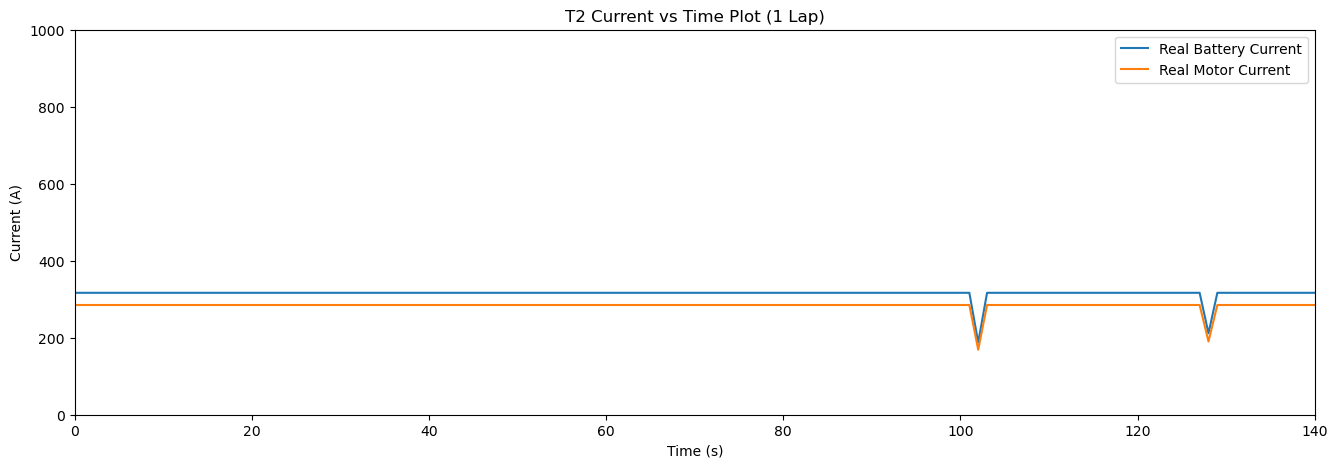

Energy per Lap (VIt): 0.895 kWh
Energy per Lap (Fvt): 0.377 kWh
Efficiency: 42.16 %


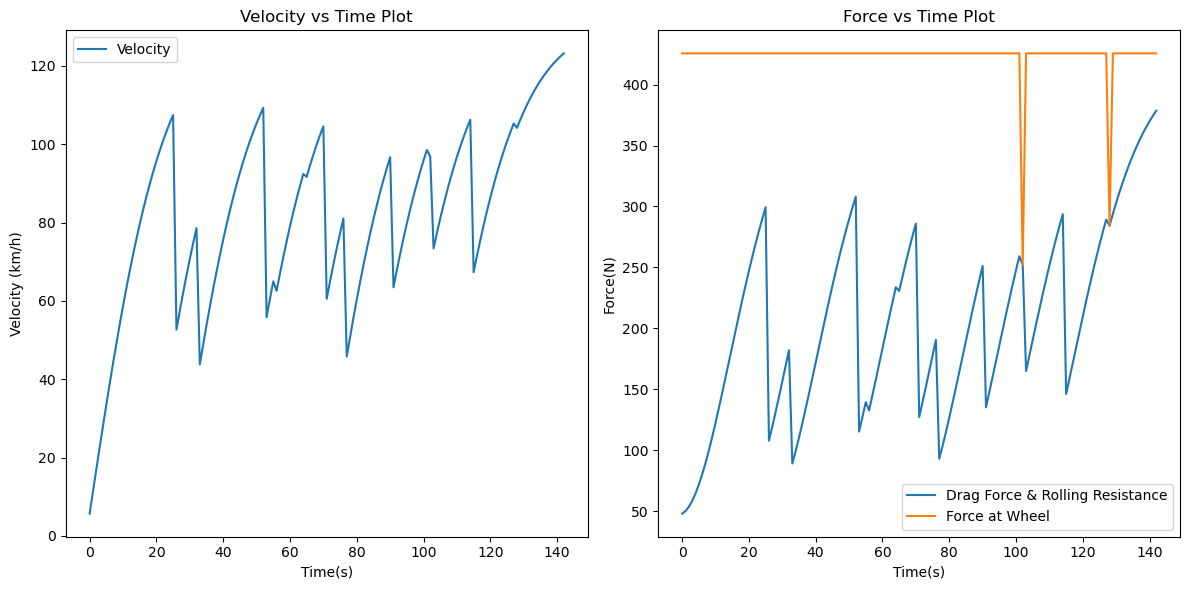

Final Temperature (1/8 inch): 861.65 C
Final Temperature (1/4 inch): 298.22 C


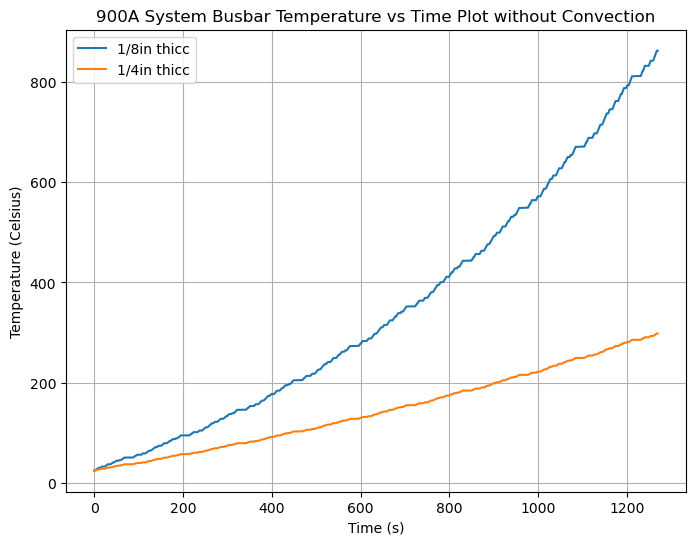

FileNotFoundError: [Errno 2] No such file or directory: 'michigan_throttle_data.csv'

In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[28]:


# Darren Liu
# Battery Intermodular Busbar Transient Heat Generation / Current vs Time Study


# In[29]:


import numpy as np
import matplotlib.pyplot as plt
import csv
import numpy as np
import scipy.integrate as integrate
import math



# ### Track Model Approach
# 

# In[30]:


mass = 240 # kg
F_n = mass * 9.81 # N
mu = 0.7
reference_area = 0.438 # m^2
r_wheel = 0.296 # m
r_r_coef = 0.02*9.81 # rolling resistance coefficient on asphalt
max_acceleration = mu * F_n / mass # m/s^2
air_density = 1.293 # kg m^3
Cd = 1
max_torque_motor = 52.2 # Nm

def find_l(r, angle):
    return 2*np.pi*r*angle/360

displacement = 0
time = 0
velocity_map = []
section_radius = [0,84,0,55,316,0,96,177,124,0,289,0,115,258,0,115,61,0,128,378,378,346,177,0,325,0,146,220,0,400,0,88]
section_length = [1423, find_l(84, 68), 350, find_l(55, 30), find_l(316, 70), 958,\
                  find_l(96, 30), find_l(177, 34), find_l(124, 46), 607, find_l(289, 20), 507, \
                  find_l(115, 34), find_l(258, 45), 135, find_l(115, 37), find_l(61, 33),\
                  880, find_l(128, 85), find_l(378,29), find_l(378, 52), find_l(346, 45), find_l(177, 90),\
                  418, find_l(325, 13), 447, find_l(146, 101), find_l(220, 67), 366, find_l(400, 76),\
                  1378, find_l(88,35)]
section_max_velocity = []

for i in range(len(section_length)):
    section_length[i] = section_length[i] * 0.3048 #convert ft to m
    
for i in range(len(section_radius)):
    section_radius[i] = section_radius[i] * 0.3048
    
for i in range(len(section_radius)):
    if section_radius[i] == 0:
        section_max_velocity.append(0)
    else:
        section_max_velocity.append(np.sqrt(mu * section_radius[i] * 9.81)) # max v based on friction and centerpedal force


# In[31]:


#***************************************** solve duration of each section***********************************************
duration = []
drag = []
v_0 = 0
for i in range(len(section_length)):
    if section_radius[i] == 0:
        t = (-v_0 + (v_0**2 + 2 * max_acceleration * section_length[i])**0.5) / max_acceleration
        duration.append(t)
        v_0 = v_0 + max_acceleration * t
    else:
        t = section_length[i] / section_max_velocity[i]
        duration.append(t)
        v_0 = section_max_velocity[i]
print('Lap Time:',sum(duration), 's')


# ### Current vs Time Duration Approach

# In[32]:


#************************************* solve for torque map at wheel (duration approach)*************************************
dt = 1
v_0 = 0
timer = 0
torque_wheel_map = []
w_e_map = []
for i in range(len(duration)):
    # re-gen modules here
    if int(section_radius[i]) == 0: # straight line
        while duration[i] > timer:
            v_0 = v_0 + max_acceleration * dt
            drag = 1/2*air_density*(v_0**2)*Cd*reference_area
            tau = (mass * max_acceleration + drag + r_r_coef * mass) * r_wheel # T = F*r
            torque_wheel_map.append(tau)
            wheel_speed = v_0 * 60 / (2 * np.pi * r_wheel)
            w_e_map.append(wheel_speed*3)
            timer += dt
        timer = 0
    else:
        while duration[i] > timer:
            v_0 = section_max_velocity[i] # turns
            drag = 1/2*air_density*(v_0**2)*Cd*reference_area
            tau = (drag + r_r_coef * mass) * r_wheel # T = F*r
            torque_wheel_map.append(tau)
            wheel_speed = v_0 * 60 / (2 * np.pi * r_wheel) # rpm
            w_e_map.append(wheel_speed*3)
            timer += dt
        timer = 0
                
        
# ***************************************solve for torque map at motor***********************************************
efficiency = 0.95
gear_ratio = 3
torque_motor_map = []
for i in range(len(torque_wheel_map)):
    tau = torque_wheel_map[i] / gear_ratio * efficiency
    if w_e_map[i] > 4000:
        tau = 96 + (4000 - w_e_map[i]) / 80 # reduction of torque due to rpm (linear fit)
        torque_motor_map.append(tau)
#        if tau > max_torque_motor:
#           tau = max_torque_motor
    else:
#        if tau > max_torque_motor:
#            tau = max_torque_motor
        torque_motor_map.append(tau)

#******************************************* solve transient current map***********************************************
V_bn = 120 # V
k_tau = 0.14 # Nm / A_rms aka T/I Constant
k_v = 0.022 # V/rad*s-1
R_m = 0.559 # Ohm
R_b = 0.4 # Ohm - Friction loss
n = 0.96 # Efficiency
PF = 0.90 # Power Factor
max_cell_voltage = 4.2 #V
nom_cell_voltage = 3.7 #V Conservative Estimate
min_cell_voltage = 3.0 #V
max_cont_current = 15 # Amps Samsung 30Q



current_map = []
current_map_2 = []
# for j in range(0,7): 7 laps
for i in range(len(torque_motor_map)):
    w_e = (2 * np.pi * w_e_map[i]) / 60 # rad/s
    tau_e = torque_motor_map[i]
    current=((tau_e*w_e)/V_bn)/PF
    current_2=(tau_e*w_e)/V_bn
#    current = (tau_e / k_tau) / PF
#    current_2 = (tau_e / k_tau)
    current_map.append(current)
    current_map_2.append(current_2)

    
#****************************************Average/Max Current at Battery and Motor***************************************    

avg_current_battery=sum(current_map)/len(current_map) #Calculates the average current the battery needs to supply
print("Average Battery Current (Continuous):",avg_current_battery)

max_current_battery = max(current_map)                 #Calculates the Peak Current the battery needs to supply
print("Peak Battery Current:",max_current_battery)

avg_current_motor=sum(current_map_2)/len(current_map_2) #Calculates the average current needed by the motor (continuos discharge)
print("Average Motor Current (Continuous):",avg_current_motor)

rms_current_motor=sum(current_map_2)/(np.sqrt(2)) #Calculates the average current needed by the motor (continuos discharge)
print("RMS Motor Current (Continuous):",rms_current_motor)

max_current_motor = max(current_map_2)   #Calculates the peak current (peak discharge) needed by the motor
print("Peak Motor Current:",max_current_motor)

avg_torque = sum(torque_motor_map)/len(torque_motor_map)   #Calculates the peak current (peak discharge) needed by the motor
print("Averge Torque:",avg_torque)

#*****************************************Number of cells in Series/Parallel and Min Voltage*********************************************
if V_bn == 120:
    cells_series=math.ceil(V_bn/nom_cell_voltage)    #Based on 120V regulation how many cells can we have in series
    print("Number of cells in Series:",cells_series)

if V_bn == 120:
    V_min = min_cell_voltage*cells_series  #Based on the max number of cells we have in series, what will the voltage be when they discharge to 3.0V
    print("Min Voltage:",V_min)  #Replace this voltage above to see max current when cells discharge to 3.0 V


cells_parallel= math.ceil(avg_current_battery/max_cont_current)  #Given a max continuous current by our cells how many cells in parallel will be need to meet our continous current demand
print("Number of cells in Parallel:",cells_parallel)


#***************************************************Battery Configuration********************************************
def battery_config(cells_series,cells_parallel):
   return f"{cells_series}S{cells_parallel}P"

print("Battery Configuration:",battery_config(cells_series,cells_parallel))



#*****************************************************Power Battery & Motor********************************************
avg_power_battery = V_bn*avg_current_battery/1000  #KW
print("Average Battery Power (Continuous):",avg_power_battery)

avg_power_motor = V_bn*avg_current_motor/1000  #KW
print("Average Motor Power (Continuous):",avg_power_motor)

Peak_power_battery = V_bn*max_current_battery/1000  #KW
print("Peak Battery Power:",Peak_power_battery)

Peak_power_motor = V_bn*max_current_motor/1000  #KW
print("Peak Motor Power:",Peak_power_motor)



#*****************************************PLOTS************************************************************************
# In[33]:


x_values = [i*dt for i in range(len(current_map))]
plt.figure(figsize=(16, 5))
plt.plot(x_values,current_map, label = 'Ideal Battery Current')
plt.plot(x_values,current_map_2, label = 'Ideal Motor Current')

plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Ideal Current vs Time Plot (1 Lap)')
plt.xlim(0,140)
plt.ylim(0,1400)
plt.legend()
plt.show()

len(x_values)
#**************************************************Motor Recommendations***************************************************

# Number 1 choice: Emrax 188


# In[34]:


#************************************************ current limiter approach*************************************************
limit = 400
limit_current_map = current_map
for i in range(len(current_map)):
    if current_map[i] > limit:
        limit_current_map[i] = limit  # current limiter
        
x_values = [i*dt for i in range(len(limit_current_map))]
plt.figure(figsize=(16, 6))
plt.plot(x_values,limit_current_map)

# Add axis labels and title
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Limited Current vs Time Plot (1 Lap)')
plt.xlim(0,120)

# Show the plot
plt.show()


# ### Current vs Time Max Velocity Approach

# In[39]:


# solve for torque map at wheel (velocity/limit current approach)
torque_wheel_map_2 = []
w_e_map_2 = []
lim_current = 300 # A
# lim_tau = k_tau * lim_current*gear_ratio
lim_tau = 126 # N/m at wheel
distance = 0
v_0 = 0

x_values = [i*dt for i in range(len(w_e_map))]
v_list = []
acc_list = []
for i in range(len(section_length)):
    distance = 0
    if section_max_velocity[i] == 0: # straight line no v limit
        while distance < section_length[i]:
            drag = 1/2*air_density*(v_0**2)*Cd*reference_area + r_r_coef * mass # F air and mechanical
            acc = (lim_tau / r_wheel - drag) / mass 
            distance += v_0 * dt + (1/2*acc*(dt**2))
            v_0 = v_0 + acc * dt
            wheel_speed = v_0 * 60 / (2 * np.pi * r_wheel) # rpm
            torque_wheel_map_2.append(lim_tau)
            w_e_map_2.append(wheel_speed*gear_ratio)
            v_list.append(v_0)
            acc_list.append(acc)
#             print('1')
            if lim_tau / r_wheel < drag: # when drag match input force
                break
        while distance < section_length[i]:
            drag = 1/2*air_density*(v_0**2)*Cd*reference_area + r_r_coef * mass # air and mechanical
            distance += v_0 * dt
            wheel_speed = v_0 * 60 / (2 * np.pi * r_wheel) # rpm
            torque_wheel_map_2.append(drag*r_wheel)
            w_e_map_2.append(wheel_speed*gear_ratio)
            v_list.append(v_0)
            acc_list.append(acc)
#             print('2')
    else:
        if v_0 > section_max_velocity[i]: # assumption of braking
            v_0 = section_max_velocity[i]
#             print('3')
        while distance < section_length[i] and v_0 < section_max_velocity[i]:
            drag = 1/2*air_density*(v_0**2)*Cd*reference_area + r_r_coef * mass # air and mechanical
            acc = (lim_tau / r_wheel - drag) / mass
            distance += v_0 * dt + (1/2*acc*(dt**2))
            v_0 = v_0 + acc * dt
            wheel_speed = v_0 * 60 / (2 * np.pi * r_wheel) # rpm
            torque_wheel_map_2.append(lim_tau)
            w_e_map_2.append(wheel_speed*gear_ratio)
            v_list.append(v_0)
            acc_list.append(acc)
#             print('4')
            if lim_tau / r_wheel < drag: # when drag match input force
#                 print('5')
                break
        while ((distance < section_length[i]) and v_0 > (section_max_velocity[i])):
            v_0 = section_max_velocity[i]
            drag = 1/2*air_density*(v_0**2)*Cd*reference_area + r_r_coef * mass # air and mechanical
            distance += v_0 * dt
            wheel_speed = v_0 * 60 / (2 * np.pi * r_wheel) # rpm
            torque_wheel_map_2.append(drag*r_wheel)
            w_e_map_2.append(wheel_speed*gear_ratio)
            v_list.append(v_0)
            acc_list.append(acc)
#             print('6')

max_torque_motor_2 = 42
# solve for torque map at motor (velocity/limit current approach)
torque_motor_map_2 = []
for i in range(len(torque_wheel_map_2)):
    tau = torque_wheel_map_2[i] / gear_ratio * efficiency
    if w_e_map_2[i] > 4000:
        tau = max_torque_motor_2 + (4000 - w_e_map_2[i]) / 80 # reduction of torque due to rpm (linear fit)
        torque_motor_map_2.append(tau)
        if tau > max_torque_motor_2:
            tau = max_torque_motor_2
    else:
        if tau > max_torque_motor_2:
            tau = max_torque_motor_2
        torque_motor_map_2.append(tau)

current_map_3 = []
current_map_4 = []
# for j in range(0,7): 7 laps
for i in range(len(torque_motor_map_2)):
    w_e = (2 * np.pi * w_e_map_2[i]) / 60 # rad/s
    tau_e = torque_motor_map_2[i]
    current_3 = (tau_e / k_tau) / PF
    current_4 = (tau_e / k_tau)
    current_map_3.append(current_3)
    current_map_4.append(current_4)


# In[40]:


x_values = [i*dt for i in range(len(current_map_3))]
plt.figure(figsize=(16, 5))
plt.plot(x_values,current_map_3, label = 'Real Battery Current')
plt.plot(x_values,current_map_4, label = 'Real Motor Current')

plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('T2 Current vs Time Plot (1 Lap)')
plt.xlim(0,140)
plt.ylim(0,1000
        )
plt.legend()
plt.show()


# #### Energy Validation

# In[41]:


# Validate energy
x_values = [i*dt for i in range(len(current_map_3))]
def integrate(x, y):
    area = np.trapz(y=y, x=x)
    return area
energy_b = 72*integrate(x_values, current_map_3)/1000/3600
print('Energy per Lap (VIt):',round(energy_b,3),'kWh') # energy one lap

# Max Energy Stand Point
energy = []
a_list = [0]
for i in range(1,len(v_list)):
    a = (v_list[i]-v_list[i-1])/dt
    if a < 0:
        a_list.append(0)
    else:
        a_list.append(a)
    
for i in range(len(v_list)):
    drag = 1/2*air_density*(v_list[i]**2)*Cd*reference_area + r_r_coef * mass
    energy.append((drag + mass*a_list[i])*v_list[i]*dt)

energy_theory = sum(energy)/1000/3600
print('Energy per Lap (Fvt):',round(energy_theory,3),'kWh') # energy one lap


print('Efficiency:',round(energy_theory/energy_b*100,2),'%') # energy one lap


# In[48]:


x_values = [i*dt for i in range(len(v_list))]
v_list_km = [v_list[i]/1000*3600 for i in range(len(v_list))]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(x_values, v_list_km, label='Velocity')
ax1.set_title('Velocity vs Time Plot')
ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Velocity (km/h)')
ax1.legend()

drag_list = [1/2*air_density*(v_list[i]**2)*Cd*reference_area + r_r_coef * mass for i in range(len(v_list))]
f_list = [acc_list[i]*mass for i in range(len(acc_list))]
total_f_list = [torque_wheel_map_2[i]/r_wheel for i in range(len(torque_wheel_map_2))]
ax2.plot(x_values, drag_list, label='Drag Force & Rolling Resistance')
# ax2.plot(x_values, f_list, label='Force acceleration')
ax2.plot(x_values, total_f_list, label='Force at Wheel')
ax2.set_title('Force vs Time Plot')
ax2.set_xlabel('Time(s)')
ax2.set_ylabel('Force(N)')
ax2.legend()

plt.tight_layout()
plt.show()


# ## Intermodular Busbar Study T2

# In[57]:


# solve for temperature change

# Define busbar parameters
length = 0.09  # meters
cross_section = 0.000053  # square meters
cross_section_2 = cross_section * 2
density = 2700  # kg/m^3
specific_heat = 910  # J/(kg*K)
thermal_conductivity = 205  # W/(m*K)
ambient_temperature = 25 # Celsius
resistivity_coefficient = 0.00429  # 1/K
resistivity_initial = 2.65e-8  # Ohm*meters
mass_busbar = length * cross_section * density
conductivity_ref = 3.5e7  # S/m
alpha = 0.0039  # 1/K
laps = 11

# Define air properties
g = 9.81  # m/s^2
beta_air = 1 / 273  # 1/K
nu_air = 1.5e-5  # m^2/s
k_air = 0.0263  # W/(m*K)

# 
def busbar_heat_generation(current_map,resistivity_initial,length,cross_section,alpha,ambient_temperature,dt,specific_heat,mass_busbar,laps):
    temperature_map = [25]
    resistance_map = [resistivity_initial]
    for j in range(1,laps):
        for i in range(len(current_map)):
            r = ((resistivity_initial * length) / cross_section) * (1 + alpha * (temperature_map[-1] - ambient_temperature))
            resistance_map.append(r)
            Q = current_map[i]**2 * resistance_map[-1] * dt
            dtemp = Q / (specific_heat * mass_busbar)
            temperature_map.append(temperature_map[-1] + dtemp)
    temperature_map.pop(0)
    return temperature_map

Temp_1 = busbar_heat_generation(current_map,resistivity_initial,length,cross_section,alpha,ambient_temperature,dt,specific_heat,mass_busbar,laps)
Temp_2 = busbar_heat_generation(current_map,resistivity_initial,length,cross_section_2,alpha,ambient_temperature,dt,specific_heat,mass_busbar,laps)

print("Final Temperature (1/8 inch):", round(Temp_1[-1],2), 'C')
print("Final Temperature (1/4 inch):", round(Temp_2[-1],2), 'C')


# In[58]:


x_values = [i*dt for i in range(len(Temp_1))]
plt.figure(figsize = (8,6))
plt.plot(x_values,Temp_1, label = '1/8in thicc')
plt.plot(x_values,Temp_2, label = '1/4in thicc')
plt.xlabel('Time (s)')
plt.ylabel('Temperature (Celsius)')
plt.title('900A System Busbar Temperature vs Time Plot without Convection')
plt.legend()
plt.grid()
plt.show()


# ## Data Prep

# In[16]:


# prepare csv file for Arduino
arduino_current_map = []
data = current_map_3

for i in range(len(data)):
    arduino_current_map.append(int(data[i] / 300 * 1023))


# In[17]:


with open('data.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(arduino_current_map)


# In[18]:


# # import serial
# # Define the serial port and baud rate
# ser = serial.Serial('COM6', 9600) # Change the COM port to match your Arduino

# # Convert the list to a string separated by commas
# data_str = ','.join(int(x) for x in arduino_current_map)

# # Send the data to the Arduino
# ser.write(data_str.encode())

# # Close the serial port
# ser.close()


# In[19]:


# creating list for ANSYS
three_column = []
amp_rn = int(data[0])
counter = 0.0
for i in range(len(data)):
    if amp_rn != int(data[i]):
        three_column.append((counter, int(amp_rn), 1))
        three_column.append((counter+0.1, int(amp_rn), 1))  
    counter = counter + 0.01
    amp_rn = int(data[i])


# In[20]:


numbers = [int(num) for num in data]
number_frequency = {}
current_number = None
for num in numbers:
    if num != current_number:
        current_number = num
        number_frequency[num] = 1
    else:
        number_frequency[num] += 1

cleaned_data = []
cleaned_data.append((0, 300, 1))
adding = 0
for num, freq in number_frequency.items():
    cleaned_data.append(((freq+adding)/100 , num, 1))
    cleaned_data.append(((freq+1+adding)/100 , num, 1))
    adding = adding + freq + 1

# cleaned_data = [(freq/100, num, 1) for num, freq in number_frequency.items()]


# In[21]:


with open("ansys_data.csv", mode='w', newline='') as file:
    writer = csv.writer(file)
    for row in cleaned_data:
        writer.writerow(row)


# ## Busbar Transient Heat Generation (Conv. PreliminaryTest)

# In[22]:


# constants
P_nom = 13000 # kW
I_nom = 156 # A
R_nom = P_nom / (I_nom**2)

# Define busbar parameters
length = 0.09  # meters
cross_section = 0.000053  # square meters
density = 2700  # kg/m^3
specific_heat = 910  # J/(kg*K)
thermal_conductivity = 205  # W/(m*K)
initial_temperature = 25  # Celsius
resistivity_coefficient = 0.00429  # 1/K
resistivity_initial = 2.65e-8  # Ohm*meters
mass_busbar = length * cross_section * density
conductivity_ref = 3.5e7  # S/m
alpha = 0.0039  # 1/K

# Define air properties
g = 9.81  # m/s^2
beta_air = 1 / 273  # 1/K
nu_air = 1.5e-5  # m^2/s
k_air = 0.0263  # W/(m*K)

# Load transient-current data from CSV file
time = []
current = []
with open('michigan_throttle_data.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # skip header row
    for row in csvreader:
        time.append(float(row[0]))
        current.append(float(row[1])*3) #every % is 3A

# Define ambient temperature
ambient_temperature = 25  # Celsius

# Define time step and simulation duration
dt = time[1] - time[0]
duration = len(time) * dt

# Initialize temperature and resistivity arrays
temperature = np.ones(len(time)) * initial_temperature
resistivity = np.ones(len(time)) * resistivity_initial

# Perform simulation
for i in range(1, len(time)):
    # Calculate Joule heating and heat transfer
    power = current[i] ** 2 * resistivity[i-1]
    Ra = g * beta_air * (temperature[i-1] - ambient_temperature) * length**3 / (nu_air * thermal_conductivity)
    Nu = 0.54 * Ra**(1/4)
    h = Nu * k_air / length
    heat_transfer = thermal_conductivity * cross_section / length * (temperature[i-1] - initial_temperature) / \
                    dt + h * cross_section / length * (temperature[i-1] - ambient_temperature)

    # Calculate temperature change
    temperature_change = (power - heat_transfer) * dt / (density * specific_heat * mass_busbar)

    # Update temperature and resistivity arrays
    temperature[i] = temperature[i-1] + temperature_change
    resistivity[i] = resistivity_initial * (1 + resistivity_coefficient * (temperature[i] - initial_temperature))

# # Plot temperature change over time
# plt.plot(time, temperature - initial_temperature)
# plt.xlabel('Time (s)')
# plt.ylabel('Temperature change (Celsius)')
# # plt.show()


# In[23]:


# Load transient-current data from CSV file
time = []
current = []
with open('michigan_throttle_data.csv', 'r') as csvfile:
    csvreader = csv.reader(csvfile)
    next(csvreader)  # skip header row
    for row in csvreader:
        time.append(float(row[0]))
        current.append(float(row[1])*3) #every % is 3A

dt = []
for i in range(len(time)-1):
    dt.append(time[i+1] - time[i])
# dt.append(5)
temperature = [25]
resistance = [(resistivity_initial * length) / cross_section]
time_x = [0]
for j in range(0,7):
    for i in range(len(dt)):
        power = current[i] ** 2 * resistance[i]
        dtemp = power / specific_heat / mass_busbar * dt[i]
        temperature.append(temperature[-1] + dtemp)
        r = resistance[0] * (1 + alpha * (temperature[-1] - ambient_temperature))
        resistance.append(r)
        time_x.append(time_x[-1] + dt[i])

# Plot temperature vs time
import matplotlib.pyplot as plt
plt.plot(time_x, temperature)
plt.xlabel('Time (s)')
plt.ylabel('Temperature (Celsius)')
plt.show()

print('Final Temperature:',temperature[-1],'C')


# In[ ]:




